# Import Libraries

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
!pip install geojson

In [129]:
pip install selenium

In [130]:
import folium
import pandas as pd
import numpy as np
import geojson
from IPython.display import display
import io
from PIL import Image
from selenium import webdriver
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# 1.0 Import Data

## 1.1 Toronto Bike Share 2019 Ridership Data

In [131]:
# Import ridership data
data_dir = '/content/drive/My Drive/MIE498 Thesis/0_Data'
merged_bike_data_2019 = pd.read_csv("{}/ridership_2019_with_bike_stations_info_20200930.csv".format(data_dir), header=0)
print(merged_bike_data_2019.shape)
merged_bike_data_2019['End Day of Year'] = merged_bike_data_2019.apply(lambda row: datetime.strptime(row['End Time'], "%Y-%m-%d %H:%M:%S").timetuple().tm_yday, axis=1)
print(merged_bike_data_2019.shape)
merged_bike_data_2019.head()

(2438720, 26)
(2438720, 27)


,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Bike Id,Start Year,Start Month,Start Hour,Start Day of Week,Start Holiday,End Year,End Month,End Hour,End Day of Week,End Holiday,Start Day of Year,Start Week of Year,Start Lat,Start Lon,End Lat,End Lon,End Day of Year
0,4581278.0,1547.0,7021.0,2019-01-01 00:08:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00,King / Cowan Ave - SMART,Annual Member,1296.0,2019.0,1.0,0.0,1.0,1.0,2019.0,1.0,0.0,1.0,1.0,1.0,1.0,43.653264,-79.382458,43.637922,-79.431734,1
1,4586979.0,1243.0,7021.0,2019-01-03 17:13:00,Bay St / Albert St,7233.0,2019-01-03 17:34:00,King / Cowan Ave - SMART,Annual Member,3168.0,2019.0,1.0,17.0,3.0,0.0,2019.0,1.0,17.0,3.0,0.0,3.0,1.0,43.653264,-79.382458,43.637922,-79.431734,3
2,4591641.0,1112.0,7021.0,2019-01-04 21:42:00,Bay St / Albert St,7233.0,2019-01-04 22:00:00,King / Cowan Ave - SMART,Annual Member,3512.0,2019.0,1.0,21.0,4.0,0.0,2019.0,1.0,22.0,4.0,0.0,4.0,1.0,43.653264,-79.382458,43.637922,-79.431734,4
3,4594328.0,1156.0,7021.0,2019-01-05 23:21:00,Bay St / Albert St,7233.0,2019-01-05 23:40:00,King / Cowan Ave - SMART,Annual Member,212.0,2019.0,1.0,23.0,5.0,0.0,2019.0,1.0,23.0,5.0,0.0,5.0,1.0,43.653264,-79.382458,43.637922,-79.431734,5
4,4596322.0,1068.0,7021.0,2019-01-06 21:42:00,Bay St / Albert St,7233.0,2019-01-06 22:00:00,King / Cowan Ave - SMART,Annual Member,3279.0,2019.0,1.0,21.0,6.0,0.0,2019.0,1.0,22.0,6.0,0.0,6.0,1.0,43.653264,-79.382458,43.637922,-79.431734,6


## 1.2 Bike Station 2019 - Neighbourhood, FSA, and DA Assignments

In [132]:
# Read station-neighbourhood mapping
df_station_assignments = pd.read_csv("{}/station_assignment.csv".format(data_dir), header=0, encoding='ISO-8859-1')
print(df_station_assignments.shape)
print(df_station_assignments.columns)
df_station_assignments.head()

(464, 7)
Index(['station_id', 'station_na', 'lat', 'lon', 'neighborhood_id', 'FSA_code',
       'da_id'],
      dtype='object')


,station_id,station_na,lat,lon,neighborhood_id,FSA_code,da_id
0,7021,Bay St / Albert St,43.653264,-79.382458,76,M5G,35204616.0
1,7160,King St W / Tecumseth St,43.643333,-79.405556,82,M5V,35204142.0
2,7012,Elizabeth St / Edward St (Bus Terminal),43.656026,-79.385327,76,M5G,35204607.0
3,7041,Edward St / Yonge St,43.656729,-79.382736,76,M5G,35204608.0
4,7275,Queen St W / James St,43.652276,-79.380701,76,M5G,35204616.0


In [133]:
# create station dictionaries
station_neigh_dict = pd.Series(df_station_assignments['neighborhood_id'].values, index=df_station_assignments['station_id']).to_dict()
station_fsa_dict = pd.Series(df_station_assignments['FSA_code'].values, index=df_station_assignments['station_id']).to_dict()
station_da_dict = pd.Series(df_station_assignments['da_id'].values, index=df_station_assignments['station_id']).to_dict()

In [134]:
# Get Columns of Data
merged_bike_data_2019.columns

Index(['Trip Id', 'Trip Duration', 'Start Station Id', 'Start Time',
       'Start Station Name', 'End Station Id', 'End Time', 'End Station Name',
       'User Type', 'Bike Id', 'Start Year', 'Start Month', 'Start Hour',
       'Start Day of Week', 'Start Holiday', 'End Year', 'End Month',
       'End Hour', 'End Day of Week', 'End Holiday', 'Start Day of Year',
       'Start Week of Year', 'Start Lat', 'Start Lon', 'End Lat', 'End Lon',
       'End Day of Year'],
      dtype='object')

## 1.3 Choropleth Data

In [135]:
def choropleth_add_columns(choropleth_data, checkout=True):
  # add new columns to trip data
  if checkout:
    # choropleth_data['Neighbourhood'] = choropleth_data.apply(lambda row: station_neigh_dict[int(row['Start Station Id'])], axis=1)
    choropleth_data['Forward_Sortation_Area'] = choropleth_data.apply(lambda row: station_fsa_dict[int(row['Start Station Id'])], axis=1)
    choropleth_data['Dissemination_Area'] = choropleth_data.apply(lambda row: station_da_dict[int(row['Start Station Id'])], axis=1)
    print(choropleth_data.shape)
    choropleth_data.dropna(inplace=True)
    print(choropleth_data.shape)
    choropleth_data['Dissemination_Area'] = choropleth_data['Dissemination_Area'].astype("int64").astype("string")
  else:
    # choropleth_data['Neighbourhood'] = choropleth_data.apply(lambda row: station_neigh_dict[int(row['End Station Id'])], axis=1)
    choropleth_data['Forward_Sortation_Area'] = choropleth_data.apply(lambda row: station_fsa_dict[int(row['End Station Id'])], axis=1)
    choropleth_data['Dissemination_Area'] = choropleth_data.apply(lambda row: station_da_dict[int(row['End Station Id'])], axis=1)
    print(choropleth_data.shape)
    choropleth_data.dropna(inplace=True)
    print(choropleth_data.shape)
    choropleth_data['Dissemination_Area'] = choropleth_data['Dissemination_Area'].astype("int64").astype("string")
  
  print(choropleth_data.dtypes)

  return choropleth_data

In [136]:
# filter for relevant data columns only
choropleth_checkout_data = merged_bike_data_2019[['Trip Id', 'Start Station Id', 'Start Day of Week', 'Start Hour', 'Start Holiday', 'Start Day of Year']]
choropleth_checkin_data = merged_bike_data_2019[['Trip Id', 'End Station Id', 'End Day of Week', 'End Hour', 'End Holiday', 'End Day of Year']]

choropleth_checkout_data = choropleth_add_columns(choropleth_checkout_data, checkout=True)
choropleth_checkin_data = choropleth_add_columns(choropleth_checkin_data, checkout=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2438720, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2428443, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Trip Id                   float64
Start Station Id          float64
Start Day of Week         float64
Start Hour                float64
Start Holiday             float64
Start Day of Year         float64
Forward_Sortation_Area     object
Dissemination_Area         string
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2438720, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(2427909, 8)
Trip Id                   float64
End Station Id            float64
End Day of Week           float64
End Hour                  float64
End Holiday               float64
End Day of Year             int64
Forward_Sortation_Area     object
Dissemination_Area         string
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [137]:
choropleth_checkout_data.head()

,Trip Id,Start Station Id,Start Day of Week,Start Hour,Start Holiday,Start Day of Year,Forward_Sortation_Area,Dissemination_Area
0,4581278.0,7021.0,1.0,0.0,1.0,1.0,M5G,35204616
1,4586979.0,7021.0,3.0,17.0,0.0,3.0,M5G,35204616
2,4591641.0,7021.0,4.0,21.0,0.0,4.0,M5G,35204616
3,4594328.0,7021.0,5.0,23.0,0.0,5.0,M5G,35204616
4,4596322.0,7021.0,6.0,21.0,0.0,6.0,M5G,35204616


In [138]:
choropleth_checkin_data.head()

,Trip Id,End Station Id,End Day of Week,End Hour,End Holiday,End Day of Year,Forward_Sortation_Area,Dissemination_Area
0,4581278.0,7233.0,1.0,0.0,1.0,1,M6K,35203170
1,4586979.0,7233.0,3.0,17.0,0.0,3,M6K,35203170
2,4591641.0,7233.0,4.0,22.0,0.0,4,M6K,35203170
3,4594328.0,7233.0,5.0,23.0,0.0,5,M6K,35203170
4,4596322.0,7233.0,6.0,22.0,0.0,6,M6K,35203170


## 1.4 Heatmap Data

In [139]:
heatmap_data = merged_bike_data_2019[['Trip Id', 'Start Station Id', 'Start Station Name', 'Start Month', 'Start Hour', 'Start Holiday', 'Start Day of Year', 'End Station Id', 'End Station Name', 'User Type']]

print(heatmap_data.shape)
# heatmap_data['Start Neighbourhood'] = heatmap_data.apply(lambda row: station_neigh_dict[int(row['Start Station Id'])], axis=1)
# heatmap_data['End Neighbourhood'] = heatmap_data.apply(lambda row: station_neigh_dict[int(row['End Station Id'])], axis=1)

heatmap_data['Start Forward_Sortation_Area'] = heatmap_data.apply(lambda row: station_fsa_dict[int(row['Start Station Id'])], axis=1)
heatmap_data['End Forward_Sortation_Area'] = heatmap_data.apply(lambda row: station_fsa_dict[int(row['End Station Id'])], axis=1)

heatmap_data['Start Dissemination_Area'] = heatmap_data.apply(lambda row: station_da_dict[int(row['Start Station Id'])], axis=1)
heatmap_data['End Dissemination_Area'] = heatmap_data.apply(lambda row: station_da_dict[int(row['End Station Id'])], axis=1)

print(heatmap_data.shape)
heatmap_data.dropna(inplace=True)
print(heatmap_data.shape)

heatmap_data['Start Dissemination_Area'] = heatmap_data['Start Dissemination_Area'].astype("int64").astype("string")
heatmap_data['End Dissemination_Area'] = heatmap_data['End Dissemination_Area'].astype("int64").astype("string")
print(heatmap_data.dtypes)

heatmap_data.head()

(2438720, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

(2438720, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2418266, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trip Id                         float64
Start Station Id                float64
Start Station Name               object
Start Month                     float64
Start Hour                      float64
Start Holiday                   float64
Start Day of Year               float64
End Station Id                  float64
End Station Name                 object
User Type                        object
Start Forward_Sortation_Area     object
End Forward_Sortation_Area       object
Start Dissemination_Area         string
End Dissemination_Area           string
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Trip Id,Start Station Id,Start Station Name,Start Month,Start Hour,Start Holiday,Start Day of Year,End Station Id,End Station Name,User Type,Start Forward_Sortation_Area,End Forward_Sortation_Area,Start Dissemination_Area,End Dissemination_Area
0,4581278.0,7021.0,Bay St / Albert St,1.0,0.0,1.0,1.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
1,4586979.0,7021.0,Bay St / Albert St,1.0,17.0,0.0,3.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
2,4591641.0,7021.0,Bay St / Albert St,1.0,21.0,0.0,4.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
3,4594328.0,7021.0,Bay St / Albert St,1.0,23.0,0.0,5.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170
4,4596322.0,7021.0,Bay St / Albert St,1.0,21.0,0.0,6.0,7233.0,King / Cowan Ave - SMART,Annual Member,M5G,M6K,35204616,35203170


# 2.0 Choropleth: Spatial Distributions
1. Assign each trip recorded to a Toronto neighbourhood (based on longitude and latitude of Start Station) --> Record in a column
  * ArcGIS (a geo-information software)

2. Average number of checkouts / Average number of checkins
  * Weekdays / Weekend + Holiday
    1. morning peak hours (7AM-10:59AM)
    2. day hours (11AM-2:59PM)
    3. evening peak hours (3PM-7:59PM)
    4. night hours (8PM-6:59AM)

In [140]:
# print('Unique number of neighbourhoods under investigation: ', len(np.unique(choropleth_checkout_data['Neighbourhood'])))
print('choropleth_checkout_data:')
print('Unique number of forward sortation areas under investigation: ', len(np.unique(choropleth_checkout_data['Forward_Sortation_Area'])))
print('Unique number of dissemination areas under investigation: ', len(np.unique(choropleth_checkout_data['Dissemination_Area'])))

print('\nchoropleth_checkin_data:')
print('Unique number of forward sortation areas under investigation: ', len(np.unique(choropleth_checkin_data['Forward_Sortation_Area'])))
print('Unique number of dissemination areas under investigation: ', len(np.unique(choropleth_checkin_data['Dissemination_Area'])))

choropleth_checkout_data:
Unique number of forward sortation areas under investigation:  38
Unique number of dissemination areas under investigation:  292

choropleth_checkin_data:
Unique number of forward sortation areas under investigation:  38
Unique number of dissemination areas under investigation:  292


## 2.1 Data Splitting

In [141]:
def split_weekday_weekendholidays(df, region_division, checkout=True):
  if checkout:
    kw = 'Start'
  else:
    kw = 'End'

  filter_weekday = (df[f'{kw} Day of Week'] >= 0) & (df[f'{kw} Day of Week'] <= 4) & (df[f'{kw} Holiday'] != 1)
  filter_weekend_holidays = (df[f'{kw} Day of Week'] == 5) | (df[f'{kw} Day of Week'] == 6) | (df[f'{kw} Holiday'] == 1)
  
  # region_division = 'Neighbourhood', 'Forward_Sortation_Area', 'Dissemination_Area'
  df_weekday = df.loc[filter_weekday][['Trip Id', f'{kw} Day of Week', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]
  df_weekend_holidays = df.loc[filter_weekend_holidays][['Trip Id', f'{kw} Day of Week', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]

  return df_weekday, df_weekend_holidays

In [142]:
def split_time_periods(df, region_division, checkout=True):
  if checkout:
    kw = 'Start'
  else:
    kw = 'End'

  filter_morning_peak_hours = (df[f'{kw} Hour'] >= 7) & (df[f'{kw} Hour'] <= 10)
  filter_day_hours = (df[f'{kw} Hour'] >= 11) & (df[f'{kw} Hour'] <= 14)
  filter_evening_peak_hours = (df[f'{kw} Hour'] >= 15) & (df[f'{kw} Hour'] <= 19)
  filter_night_hours = ((df[f'{kw} Hour'] >= 20) & (df[f'{kw} Hour'] <= 23)) | ((df[f'{kw} Hour'] >= 0) & (df[f'{kw} Hour'] <= 6))

  # region_division = 'Neighbourhood', 'Forward_Sortation_Area', 'Dissemination_Area'
  df_morning_peak_hours = df.loc[filter_morning_peak_hours][['Trip Id', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]
  df_day_hours = df.loc[filter_day_hours][['Trip Id', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]
  df_evening_peak_hours = df.loc[filter_evening_peak_hours][['Trip Id', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]
  df_night_hours = df.loc[filter_night_hours][['Trip Id', f'{kw} Hour', f'{kw} Station Id', region_division, f'{kw} Day of Year']]
  print(df_morning_peak_hours.dtypes)

  return [df_morning_peak_hours, df_day_hours, df_evening_peak_hours, df_night_hours]

In [143]:
# # Test example
# df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkout_data, 'Forward_Sortation_Area')
# print('df_weekday: {}, df_weekend_holidays: {}'.format(df_weekday.shape, df_weekend_holidays.shape))
# print(choropleth_data.shape[0])
# print(1775868+652575)
# print()
# print(len(df_weekday))
# df1, df2, df3, df4 = split_time_periods(df_weekday, 'Forward_Sortation_Area')
# print(len(df1)+len(df2)+len(df3)+len(df4))

## 2.2 Create Choropleth Maps Functions

In [144]:
# File paths of Toronto fsa and da geojson files
toronto_fsa_geo = "/content/drive/My Drive/MIE498 Thesis/0_Data/TorontoFSAs.geojson"
toronto_da_geo = "/content/drive/My Drive/MIE498 Thesis/0_Data/TorontoDAsSmaller.geojson"

In [145]:
# maxval = 9
# minval = 0
# stepsize = (maxval - minval) / 5
# list(np.arange(minval, maxval+stepsize, stepsize)[0:6])

In [146]:
def create_choropleth_map(trip_counts_all_data, trip_counts_data, plot_name, geojsonfile, df_columns, key_string, custom_bins=None):
  f = folium.Figure(width=1000, height=500)

  # create initial map
  choropleth_map = folium.Map(location=[df_station_assignments['lat'].mean(), df_station_assignments['lon'].mean()], zoom_start=11.5, control_scale=True).add_to(f)

  # customize bins to divide up data by quantiles
  if custom_bins is None:
    # maxval, minval = trip_counts_all_data["Normalized_Avg_Daily_Numbers"].max(), trip_counts_all_data["Normalized_Avg_Daily_Numbers"].min()
    # stepsize = (maxval - minval) / 5
    # custom_bins = list(np.arange(minval, maxval+stepsize, stepsize)[0:6])

    # custom_bins = list(trip_counts_all_data["Log_Normalized_Avg_Daily_Numbers"].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    custom_bins = list(trip_counts_data["Log_Normalized_Avg_Daily_Numbers"].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]))
  print(custom_bins)
  print(10 ** np.array(custom_bins))
  
  # create choropleth map
  # https://github.com/python-visualization/folium/blob/v0.2.0/folium/utilities.py#L112 --> for changing fill_color
  folium.Choropleth(
      geo_data=geojsonfile, 
      data = trip_counts_data,
      columns = df_columns,
      key_on=key_string,
      fill_color = "PiYG", #YlGnBu; PRGn
      fill_opacity=0.7,
      line_opacity=0.7,
      bins=custom_bins,
      legend_name='Log Normalized Average Daily Numbers',
      reset=True,
  ).add_to(choropleth_map)
  # ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, *‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’

  # display map
  choropleth_map.save(f"{df_columns[0]}-{plot_name}.html")
  print(plot_name)
  display(choropleth_map)
  # return choropleth_map

In [147]:
def choropleth_maps_by_timeofday(data, plot_type, region_division, geojsonfile, df_columns, key_string, checkout=True, custom_bins=None):
  # plot_type = ['Weekdays', 'Weekends_Holidays']
  # region_division = 'Neighbourhood', 'Forward_Sortation_Area', 'Dissemination_Area'
  # Both casual and annual users
  if checkout:
    kw = 'Start'
    kw2 = 'Checkout'
  else:
    kw = 'End'
    kw2 = 'Checkin'
  
  num_days = len(np.unique(data[f'{kw} Day of Year']))
  plot_names = ['Morning Peak Hours', 'Day Hours', 'Evening Peak Hours', 'Night Hours']
  # total_num_trips = data['Trip Id'].count()

  # Split data into 4 dataframes (4 different periods of time)
  df_list = split_time_periods(data, region_division, checkout)
  df_trip_counts_list = []
  count = 0
    
  for df in df_list:
    # Compute trip counts by region
    total_num_trips = df['Trip Id'].count()
    trip_counts = df[['Trip Id', region_division]].groupby(by=[region_division]).count()
    print(trip_counts.head())
    # Compute normalized average daily trip counts wrt total trip counts
    trip_counts['Trip Id'] = trip_counts['Trip Id'].div(num_days)
    # trip_counts['Trip Id'] = trip_counts['Trip Id'].div(total_num_trips)
    trip_counts['Trip Id'] = trip_counts['Trip Id'].div(total_num_trips / num_days)
    # trip_counts['Trip Id'] = trip_counts['Trip Id'].div(0.01)
    print(trip_counts.head())
    print('Normalization check: ', trip_counts['Trip Id'].sum())
    trip_counts['Trip Id'] = np.log10(trip_counts['Trip Id'])
    # Rename the column
    trip_counts.rename(columns={'Trip Id': 'Log_Normalized_Avg_Daily_Numbers'}, inplace=True)
    trip_counts.reset_index(inplace=True)
    df_trip_counts_list.append(trip_counts)
    # count += trip_counts['Log_Normalized_Avg_Daily_Numbers'].sum()
  
  trip_counts_all = pd.concat([df_trip_counts_list[0], df_trip_counts_list[1], df_trip_counts_list[2], df_trip_counts_list[3]])

  for i, df in enumerate(df_list):
    # call previous function to create choropleth maps
    create_choropleth_map(trip_counts_all, df_trip_counts_list[i], f'{kw2}_{plot_type}_{plot_names[i]}', geojsonfile, df_columns, key_string, custom_bins)

  # print('final=', count)

In [148]:
# geo_data=toronto_neighbourhood_geo, toronto_fsa_geo, toronto_da_geo
# data = trip_counts_data,
# columns = ['Neighbourhood', 'Number of Trips'], ['Forward_Sortation_Area', 'Number of Trips'], ['Dissemination_Area', 'Number of Trips']
# key_on='feature.properties.AREA_LONG_CODE', 'feature.properties.CFSAUID', 'feature.properties.DAUID'

## 2.3 Checkouts

### 2.3.1 Weekdays Choropleth Maps

In [122]:
# bins_division = [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 4.5] # Percent of total of all regions
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkout_data, 'Dissemination_Area', checkout=True)
choropleth_maps_by_timeofday(df_weekday, 'Weekdays', 'Dissemination_Area', toronto_da_geo, ['Dissemination_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.DAUID', checkout=True, custom_bins=None)

# bins_division = [0, 0.001, 0.035, 0.13, 0.375, 1.05, 1.85, 5.75]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkout_data, 'Forward_Sortation_Area', checkout=True)
choropleth_maps_by_timeofday(df_weekday, 'Weekdays', 'Forward_Sortation_Area', toronto_fsa_geo, ['Forward_Sortation_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.CFSAUID', checkout=True, custom_bins=None)

Output hidden; open in https://colab.research.google.com to view.

### 2.3.2 Weekends & Holidays Choropleth Maps

In [123]:
bins_division = [0, 0.0003, 0.01, 0.02, 0.05, 0.1, 0.2, 2.9]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkout_data, 'Dissemination_Area', checkout=True)
choropleth_maps_by_timeofday(df_weekend_holidays, 'Weekends_Holidays', 'Dissemination_Area', toronto_da_geo, ['Dissemination_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.DAUID', checkout=True, custom_bins=None)

bins_division = [0, 0.002, 0.04, 0.18, 0.43, 1.07, 1.8, 6.5]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkout_data, 'Forward_Sortation_Area', checkout=True)
choropleth_maps_by_timeofday(df_weekend_holidays, 'Weekends_Holidays', 'Forward_Sortation_Area', toronto_fsa_geo, ['Forward_Sortation_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.CFSAUID', checkout=True, custom_bins=None)

Output hidden; open in https://colab.research.google.com to view.

## 2.4 Checkins

### 2.4.1 Weekdays Choropleth Maps

In [124]:
# bins_division = [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 4.5] # Percent of total of all regions
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkin_data, 'Dissemination_Area', checkout=False)
choropleth_maps_by_timeofday(df_weekday, 'Weekdays', 'Dissemination_Area', toronto_da_geo, ['Dissemination_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.DAUID', checkout=False, custom_bins=None)

# bins_division = [0, 0.001, 0.035, 0.13, 0.375, 1.05, 1.85, 5.75]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkin_data, 'Forward_Sortation_Area', checkout=False)
choropleth_maps_by_timeofday(df_weekday, 'Weekdays', 'Forward_Sortation_Area', toronto_fsa_geo, ['Forward_Sortation_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.CFSAUID', checkout=False, custom_bins=None)

Output hidden; open in https://colab.research.google.com to view.

### 2.4.2 Weekends & Holidays Choropleth Maps

In [125]:
# bins_division = [0, 0.0003, 0.01, 0.02, 0.05, 0.1, 0.2, 2.9]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkin_data, 'Dissemination_Area', checkout=False)
choropleth_maps_by_timeofday(df_weekend_holidays, 'Weekends_Holidays', 'Dissemination_Area', toronto_da_geo, ['Dissemination_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.DAUID', checkout=False, custom_bins=None)

# bins_division = [0, 0.002, 0.04, 0.18, 0.43, 1.07, 1.8, 6.5]
df_weekday, df_weekend_holidays = split_weekday_weekendholidays(choropleth_checkin_data, 'Forward_Sortation_Area', checkout=False)
choropleth_maps_by_timeofday(df_weekend_holidays, 'Weekends_Holidays', 'Forward_Sortation_Area', toronto_fsa_geo, ['Forward_Sortation_Area', 'Log_Normalized_Avg_Daily_Numbers'], 'feature.properties.CFSAUID', checkout=False, custom_bins=None)

Output hidden; open in https://colab.research.google.com to view.

# 3.0 Transition Matrix Heatmap

## 3.1 Function Definitions & Data Splitting

In [206]:
def split_seasons_transition_matrix(df):
  filter_spring_fall = (df['Start Month'] == 4) | (df['Start Month'] == 5) | (df['Start Month'] == 10) | (df['Start Month'] == 11) # months: apr, may, oct, nov
  filter_summer = (df['Start Month'] == 6) | (df['Start Month'] == 7) | (df['Start Month'] == 8) | (df['Start Month'] == 9) # months: jun - sep
  filter_winter = (df['Start Month'] == 12) | (df['Start Month'] == 1) | (df['Start Month'] == 2) | (df['Start Month'] == 3)  # months: dec, jan - mar

  df_spring_fall = df.loc[filter_spring_fall]
  df_summer = df.loc[filter_summer]
  df_winter = df.loc[filter_winter]

  return df_spring_fall, df_summer, df_winter

In [207]:
heatmap_spring_fall, heatmap_summer, heatmap_winter = split_seasons_transition_matrix(heatmap_data)

In [208]:
# print(len(np.unique(heatmap_summer['Start Neighbourhood'])), len(np.unique(heatmap_summer['End Neighbourhood'])))
print(len(np.unique(heatmap_summer['Start Forward_Sortation_Area'])), len(np.unique(heatmap_summer['End Forward_Sortation_Area'])))
print(len(np.unique(heatmap_summer['Start Dissemination_Area'])), len(np.unique(heatmap_summer['End Dissemination_Area'])))

38 38
292 292


In [229]:
def compute_heatmap(df_season, region_division, hm_size):
  unique_start = list(np.unique(df_season['Start {}'.format(region_division)]))  
  df_season_pivoted = pd.DataFrame(data=np.zeros((hm_size, hm_size)), columns = unique_start, index=unique_start)
  df_season_pivoted = df_season_pivoted.astype("int")
  
  num_days = len(np.unique(df_season['Start Day of Year']))

  # for each Start Station
  for start_n in unique_start:
    df_start_neigh = df_season[df_season['Start {}'.format(region_division)] == start_n]
    df_counts = pd.DataFrame(df_start_neigh['End {}'.format(region_division)].value_counts())
    df_counts.rename(columns={f'End {region_division}': 'Average Number of Trips'}, inplace=True)
    df_counts['Average Number of Trips'] = df_counts['Average Number of Trips'].div(num_days)
    
    # print(df_counts.head())
    region_list = list(df_counts.index)
    
    for end_n in region_list:
      cnt = df_counts.loc[end_n]['Average Number of Trips']
      df_season_pivoted.loc[start_n, end_n] = cnt
  
  df_season_pivoted = df_season_pivoted.div(df_season_pivoted.sum(axis=1), axis=0)
  return df_season_pivoted

In [210]:
def plot_heatmap(hm_matrix, plot_name, figure_size=(40, 15)):
  fig = plt.figure(figsize=figure_size)
  sns.heatmap(hm_matrix, cmap='PuBuGn')  # tab20c, twilight, coolwarm
  fig.savefig(f'{plot_name}.png')
  plt.show()

heatmap_spring_fall, heatmap_summer, heatmap_winter

## 3.2 Spring + Fall

Forward Sortation Area
Max Value:  0.46425419240953225


,M1L,M3C,M4C,M4E,M4J,M4K,M4L,M4M,M4P,M4R,M4S,M4T,M4V,M4W,M4X,M4Y,M5A,M5B,M5C,M5E,M5G,M5H,M5J,M5N,M5P,M5R,M5S,M5T,M5V,M6C,M6G,M6H,M6J,M6K,M6P,M6R,M6S,M8V
M1L,0.107692,0.023077,0.130769,0.353846,0.084615,0.038462,0.169231,0.007692,0.000000,0.000000,0.000000,0.007692,0.000000,0.000000,0.000000,0.000000,0.015385,0.007692,0.000000,0.000000,0.000000,0.007692,0.000000,0.000000,0.000000,0.015385,0.023077,0.000000,0.000000,0.000000,0.000000,0.007692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M3C,0.011364,0.340909,0.056818,0.000000,0.000000,0.352273,0.000000,0.000000,0.079545,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.034091,0.000000,0.000000,0.000000,0.034091,0.011364,0.000000,0.000000,0.011364,0.000000,0.011364,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M4C,0.013328,0.001523,0.278370,0.051790,0.064356,0.111577,0.094440,0.071211,0.000000,0.000000,0.000000,0.000381,0.001142,0.068926,0.007235,0.031607,0.088728,0.004570,0.008378,0.003046,0.046839,0.008378,0.004189,0.000000,0.000381,0.008378,0.012947,0.007616,0.004570,0.000000,0.000762,0.000762,0.000381,0.000000,0.000381,0.000381,0.003427,0.000000
M4E,0.011700,0.000000,0.028081,0.343994,0.004680,0.019891,0.176287,0.222309,0.000000,0.000000,0.000000,0.000000,0.000390,0.004680,0.001950,0.000780,0.115835,0.001950,0.007020,0.003900,0.003120,0.020671,0.022231,0.000000,0.000000,0.000000,0.000780,0.002340,0.006240,0.000000,0.000000,0.000000,0.000390,0.000000,0.000000,0.000000,0.000780,0.000000
M4J,0.004719,0.000429,0.085371,0.008580,0.143715,0.136422,0.062205,0.141570,0.001287,0.000000,0.000429,0.000429,0.000429,0.032175,0.014586,0.039897,0.126555,0.027027,0.007722,0.001287,0.034749,0.018447,0.007722,0.000000,0.002574,0.014586,0.027027,0.045045,0.006006,0.000000,0.003432,0.000429,0.004290,0.000000,0.000000,0.000000,0.000858,0.000000
M4K,0.000565,0.002372,0.043719,0.004519,0.047560,0.243787,0.009376,0.090601,0.000226,0.000339,0.000565,0.003615,0.001695,0.037958,0.016832,0.053547,0.138048,0.025983,0.015590,0.002146,0.071396,0.039426,0.026661,0.000000,0.001130,0.018301,0.044849,0.026548,0.021012,0.000000,0.006326,0.001243,0.002598,0.000565,0.000339,0.000000,0.000565,0.000000
M4L,0.000943,0.000000,0.021462,0.126887,0.016981,0.016274,0.180425,0.178774,0.000000,0.000000,0.000000,0.000000,0.000000,0.001887,0.001415,0.019340,0.180425,0.029481,0.033255,0.010377,0.028774,0.045519,0.056604,0.000000,0.000000,0.000472,0.013208,0.017925,0.015566,0.000000,0.000472,0.000472,0.001415,0.001415,0.000000,0.000236,0.000000,0.000000
M4M,0.000000,0.000113,0.009678,0.046815,0.012098,0.030835,0.059926,0.238465,0.000619,0.000056,0.000281,0.000506,0.003939,0.004727,0.006302,0.021607,0.212975,0.034267,0.023970,0.009734,0.043158,0.068929,0.074837,0.000000,0.000113,0.003320,0.010804,0.024139,0.043608,0.000056,0.001857,0.000338,0.008722,0.002645,0.000056,0.000056,0.000281,0.000169
M4P,0.000000,0.003309,0.002481,0.000000,0.002481,0.009926,0.000000,0.008271,0.278743,0.047146,0.037221,0.016543,0.086849,0.043838,0.006617,0.092639,0.043838,0.011580,0.010753,0.001654,0.016543,0.011580,0.006617,0.016543,0.059553,0.080232,0.049628,0.014888,0.009098,0.006617,0.019024,0.000827,0.000827,0.001654,0.001654,0.000827,0.000000,0.000000
M4R,0.000000,0.000000,0.000000,0.000000,0.000000,0.009375,0.000000,0.009375,0.056250,0.028125,0.037500,0.059375,0.240625,0.056250,0.000000,0.031250,0.018750,0.018750,0.000000,0.000000,0.025000,0.043750,0.021875,0.018750,0.109375,0.071875,0.059375,0.009375,0.000000,0.009375,0.012500,0.043750,0.000000,0.006250,0.000000,0.003125,0.000000,0.000000


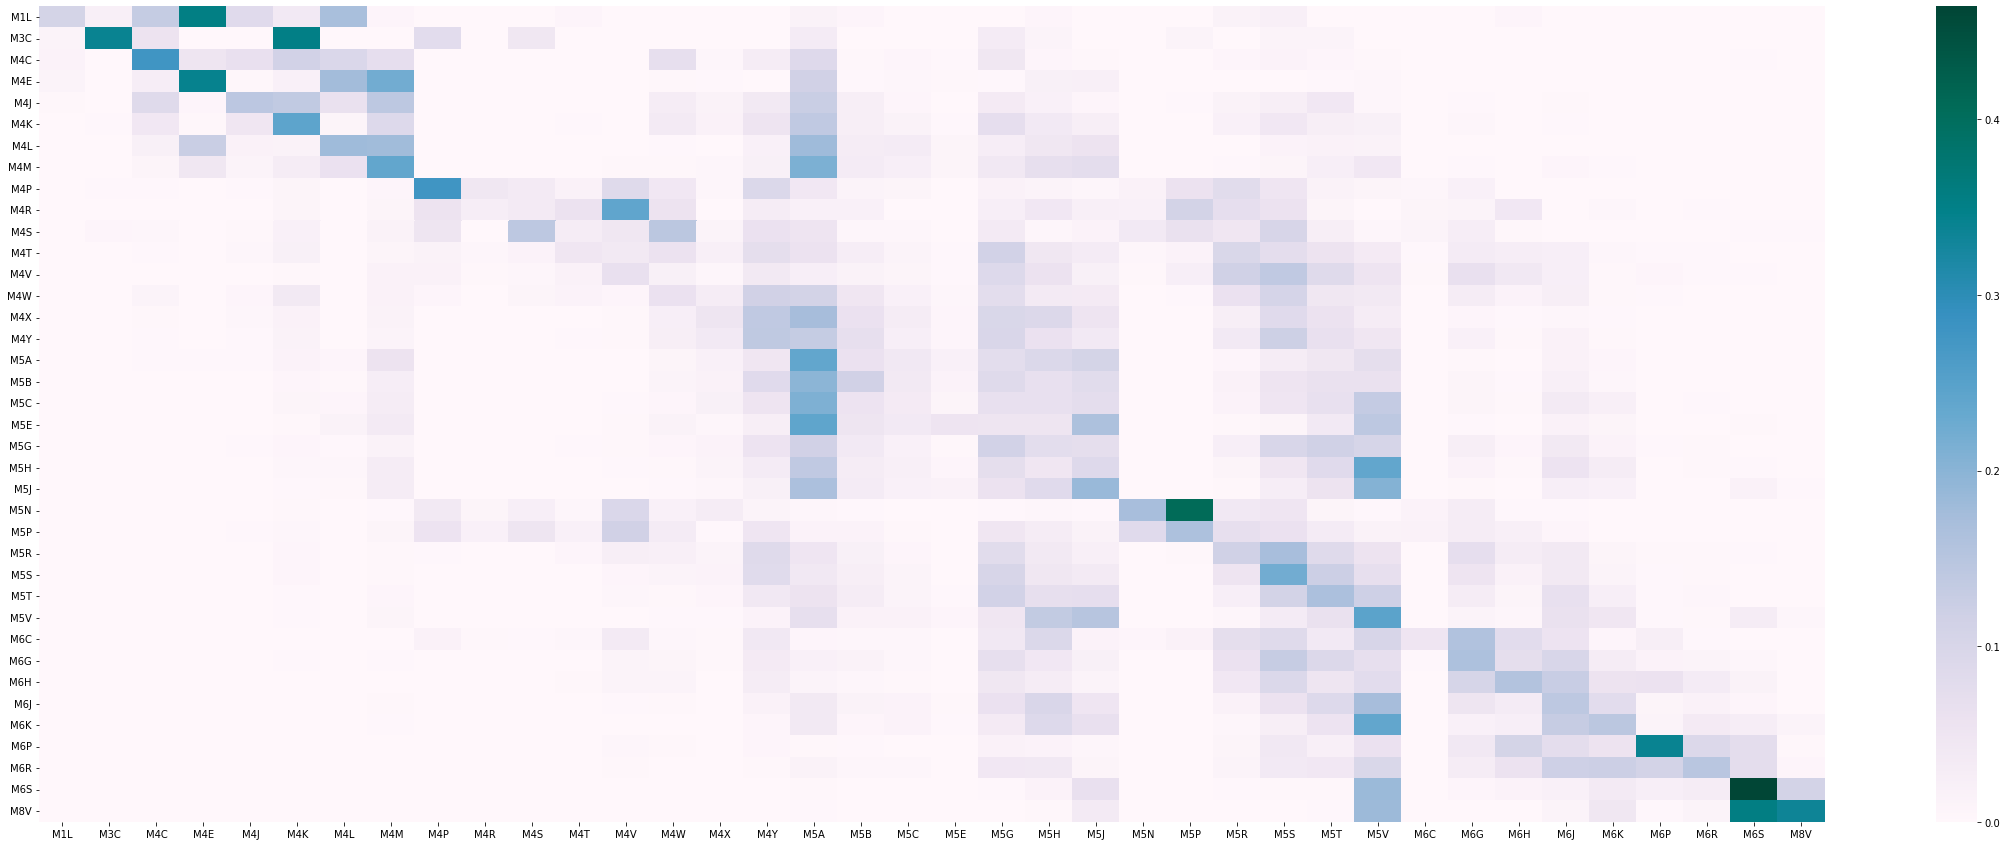

Dissemination Area
Max Value:  0.5261603375527426


,35200523,35200567,35200576,35200583,35200588,35200591,35200596,35200598,35200605,35200643,35200654,35200660,35200674,35200678,35200696,35200703,35200705,35200708,35200710,35200732,35200737,35200741,35200745,35200747,35200749,35200751,35200757,35200771,35200783,35200791,35200792,35200797,35200801,35200805,35200813,35200821,35200822,35200826,35200832,35200833,...,35204625,35204632,35204634,35204653,35204655,35204661,35204663,35204666,35204675,35204692,35204749,35204750,35204757,35204819,35204820,35204822,35204825,35204826,35204827,35204841,35204842,35204843,35204844,35204845,35204867,35204871,35204872,35204873,35204881,35204882,35204883,35204888,35204894,35204895,35204896,35204897,35204898,35204899,35204900,35204901
35200523,0.068376,0.076923,0.034188,0.025641,0.076923,0.025641,0.008547,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.017094,0.000000,0.000000,0.008547,0.000000,0.085470,0.042735,0.034188,0.000000,0.000000,0.0,0.025641,0.000000,0.000000,0.059829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200567,0.040590,0.044280,0.000000,0.007380,0.011070,0.003690,0.007380,0.003690,0.022140,0.000000,0.003690,0.000000,0.007380,0.000000,0.003690,0.018450,0.003690,0.011070,0.018450,0.055351,0.011070,0.022140,0.007380,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.007380,0.000000,0.000000,0.003690,0.003690,0.000000,0.003690,0.000000,0.000000,0.007380,0.000000,...,0.000000,0.000000,0.007380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003690,0.007380,0.0,0.000000,0.000000,0.000000,0.003690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003690
35200576,0.035336,0.024735,0.028269,0.021201,0.098940,0.042403,0.003534,0.007067,0.014134,0.000000,0.000000,0.003534,0.000000,0.000000,0.000000,0.007067,0.003534,0.003534,0.017668,0.038869,0.010601,0.017668,0.000000,0.000000,0.000000,0.0,0.003534,0.000000,0.035336,0.007067,0.003534,0.014134,0.003534,0.003534,0.003534,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003534,0.000000,0.000000,0.000000,0.000000,0.003534,0.0,0.000000,0.000000,0.000000,0.063604,0.000000,0.003534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200583,0.001727,0.005181,0.015544,0.024180,0.015544,0.043178,0.008636,0.017271,0.006908,0.005181,0.008636,0.001727,0.006908,0.012090,0.003454,0.025907,0.003454,0.006908,0.034542,0.008636,0.005181,0.029361,0.000000,0.000000,0.000000,0.0,0.001727,0.000000,0.017271,0.003454,0.001727,0.003454,0.003454,0.005181,0.000000,0.000000,0.001727,0.000000,0.003454,0.000000,...,0.000000,0.000000,0.006908,0.001727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020725,0.000000,0.000000,0.000000,0.000000,0.000000,0.001727,0.000000,0.000000,0.000000,0.000000,0.000000,0.001727,0.0,0.000000,0.000000,0.000000,0.008636,0.000000,0.000000,0.000000,0.001727,0.000000,0.003454,0.000000,0.000000,0.005181,0.000000,0.001727
35200588,0.014516,0.006452,0.045161,0.032258,0.032258,0.035484,0.006452,0.017742,0.011290,0.009677,0.022581,0.000000,0.014516,0.003226,0.001613,0.020968,0.001613,0.009677,0.011290,0.000000,0.000000,0.022581,0.000000,0.000000,0.001613,0.0,0.003226,0.000000,0.008065,0.003226,0.001613,0.029032,0.000000,0.004839,0.000000,0.001613,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000

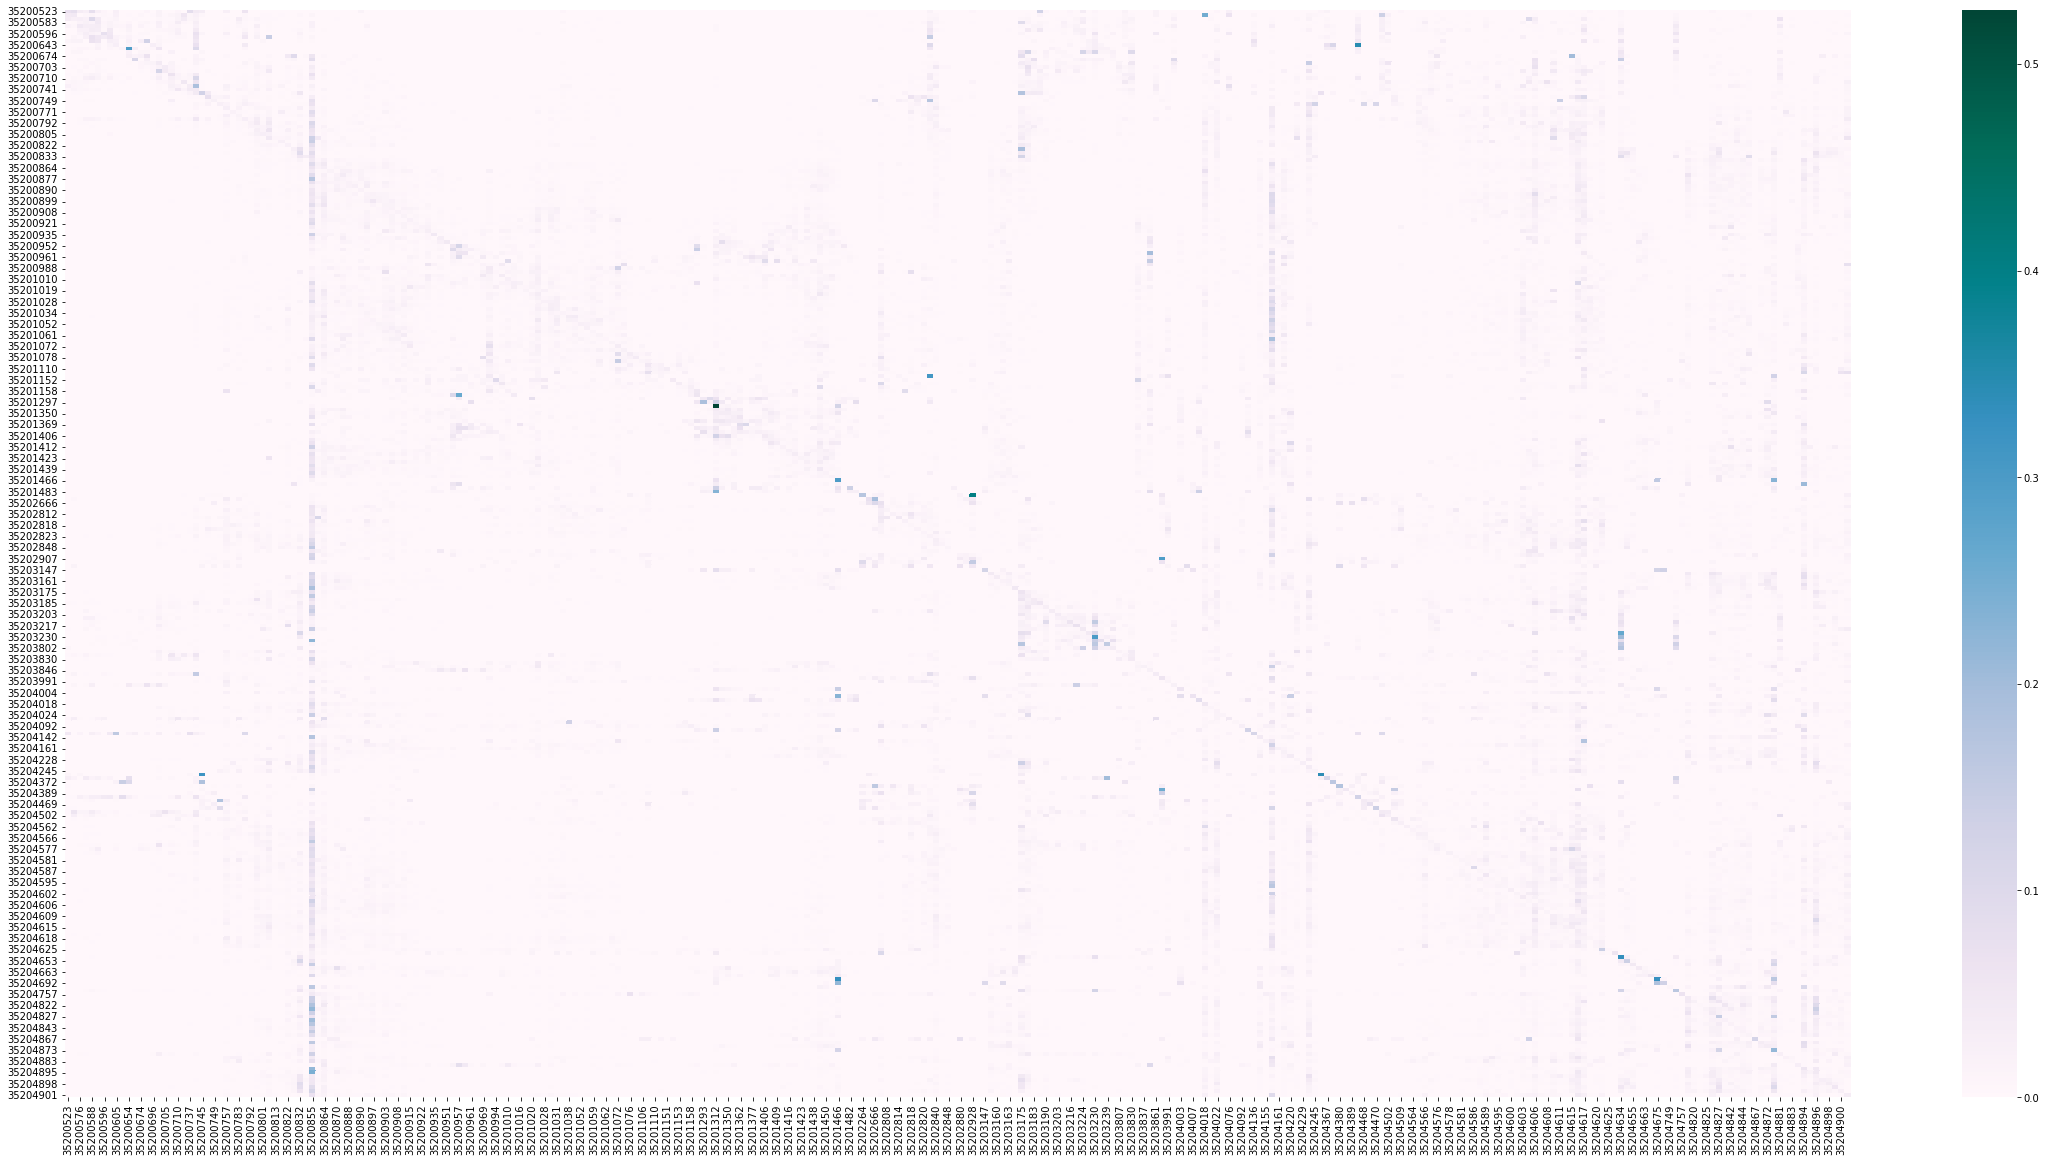

In [231]:
# 'Neighbourhood', 50 / 'Forward_Sortation_Area', 38 / 'Dissemination_Area', 292, for plotting DA: (40, 20)
# print('Neighbourhood')
# heatmap_matrix = compute_heatmap(heatmap_spring_fall, 'Neighbourhood', 50)
# print('Max Value: ', heatmap_matrix.to_numpy().max())
# display(heatmap_matrix)
# plot_heatmap(heatmap_matrix, 'Neighbourhood-springfall')

print('Forward Sortation Area')
heatmap_matrix = compute_heatmap(heatmap_spring_fall, 'Forward_Sortation_Area', 38)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Forward_Sortation_Area-springfall')

print('Dissemination Area')
heatmap_matrix = compute_heatmap(heatmap_spring_fall, 'Dissemination_Area', 292)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Dissemination_Area-springfall', (40, 20))

## 3.3 Summer

Forward Sortation Area
Max Value:  0.504950495049505


,M1L,M3C,M4C,M4E,M4J,M4K,M4L,M4M,M4P,M4R,M4S,M4T,M4V,M4W,M4X,M4Y,M5A,M5B,M5C,M5E,M5G,M5H,M5J,M5N,M5P,M5R,M5S,M5T,M5V,M6C,M6G,M6H,M6J,M6K,M6P,M6R,M6S,M8V
M1L,0.164444,0.008889,0.208889,0.217778,0.040000,0.106667,0.066667,0.017778,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.048889,0.035556,0.000000,0.000000,0.000000,0.000000,0.000000,0.031111,0.000000,0.004444,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M3C,0.004950,0.504950,0.047030,0.000000,0.014851,0.202970,0.000000,0.012376,0.061881,0.000000,0.012376,0.004950,0.002475,0.014851,0.000000,0.000000,0.056931,0.000000,0.002475,0.004950,0.007426,0.000000,0.004950,0.000000,0.012376,0.000000,0.019802,0.002475,0.000000,0.000000,0.000000,0.000000,0.000000,0.004950,0.000000,0.000000,0.000000,0.000000
M4C,0.015294,0.001474,0.307721,0.081445,0.063387,0.116823,0.100055,0.069467,0.000921,0.000000,0.000553,0.000184,0.000553,0.051410,0.003132,0.027455,0.072600,0.003685,0.004975,0.000737,0.035194,0.007371,0.005528,0.000000,0.000369,0.003685,0.013820,0.004422,0.004238,0.000000,0.001290,0.000000,0.000737,0.000184,0.000921,0.000184,0.000184,0.000000
M4E,0.004839,0.000000,0.026382,0.351152,0.005991,0.011290,0.152765,0.261866,0.000115,0.000000,0.000000,0.000000,0.000000,0.003917,0.001382,0.004032,0.109793,0.005415,0.003341,0.004378,0.003111,0.008756,0.023157,0.000000,0.000000,0.000922,0.001728,0.002650,0.008295,0.000000,0.000346,0.000115,0.001959,0.001613,0.000230,0.000000,0.000230,0.000230
M4J,0.003506,0.000234,0.085788,0.015895,0.153109,0.120383,0.078541,0.136746,0.001870,0.000000,0.000701,0.000701,0.001169,0.029453,0.013558,0.042309,0.142122,0.021739,0.005376,0.000935,0.027583,0.022207,0.006311,0.000234,0.000000,0.011921,0.033894,0.028986,0.007714,0.000000,0.002571,0.000935,0.001870,0.001169,0.000234,0.000000,0.000234,0.000000
M4K,0.001194,0.004837,0.048014,0.005494,0.037265,0.235354,0.019349,0.085279,0.001135,0.000060,0.000657,0.003703,0.001374,0.041804,0.017557,0.055718,0.159749,0.029681,0.015527,0.002210,0.055360,0.031950,0.026695,0.000060,0.000896,0.019409,0.040072,0.021917,0.020961,0.000119,0.007525,0.002807,0.003941,0.001553,0.000299,0.000119,0.000239,0.000119
M4L,0.000872,0.000159,0.018633,0.137726,0.015382,0.014906,0.184428,0.211307,0.000079,0.000000,0.000000,0.000079,0.000159,0.002854,0.004520,0.019743,0.195528,0.024025,0.011576,0.006898,0.018950,0.024580,0.057644,0.000000,0.000000,0.002775,0.004916,0.013003,0.023311,0.000000,0.000555,0.000159,0.002854,0.001269,0.000238,0.000000,0.000317,0.000555
M4M,0.000065,0.000043,0.006526,0.062908,0.009713,0.024724,0.078199,0.292744,0.000366,0.000000,0.000108,0.000668,0.001443,0.004846,0.005104,0.018284,0.208365,0.027976,0.015183,0.012448,0.027976,0.042190,0.080072,0.000000,0.000258,0.003230,0.007947,0.015808,0.037775,0.000000,0.001335,0.000603,0.007882,0.003898,0.000151,0.000129,0.000689,0.000345
M4P,0.000000,0.015390,0.001074,0.002147,0.003221,0.020043,0.001432,0.015748,0.197208,0.022548,0.039012,0.034001,0.069435,0.050465,0.003937,0.089120,0.044739,0.009306,0.008948,0.000358,0.029707,0.018253,0.011095,0.011811,0.068003,0.106657,0.056908,0.015032,0.010737,0.010021,0.018969,0.005727,0.005369,0.001790,0.000716,0.000000,0.001074,0.000000
M4R,0.000000,0.013208,0.001887,0.000000,0.001887,0.003774,0.000000,0.009434,0.084906,0.077358,0.033962,0.054717,0.122642,0.032075,0.003774,0.037736,0.033962,0.013208,0.003774,0.000000,0.077358,0.058491,0.015094,0.028302,0.111321,0.064151,0.058491,0.009434,0.003774,0.001887,0.009434,0.022642,0.005660,0.001887,0.000000,0.001887,0.001887,0.000000


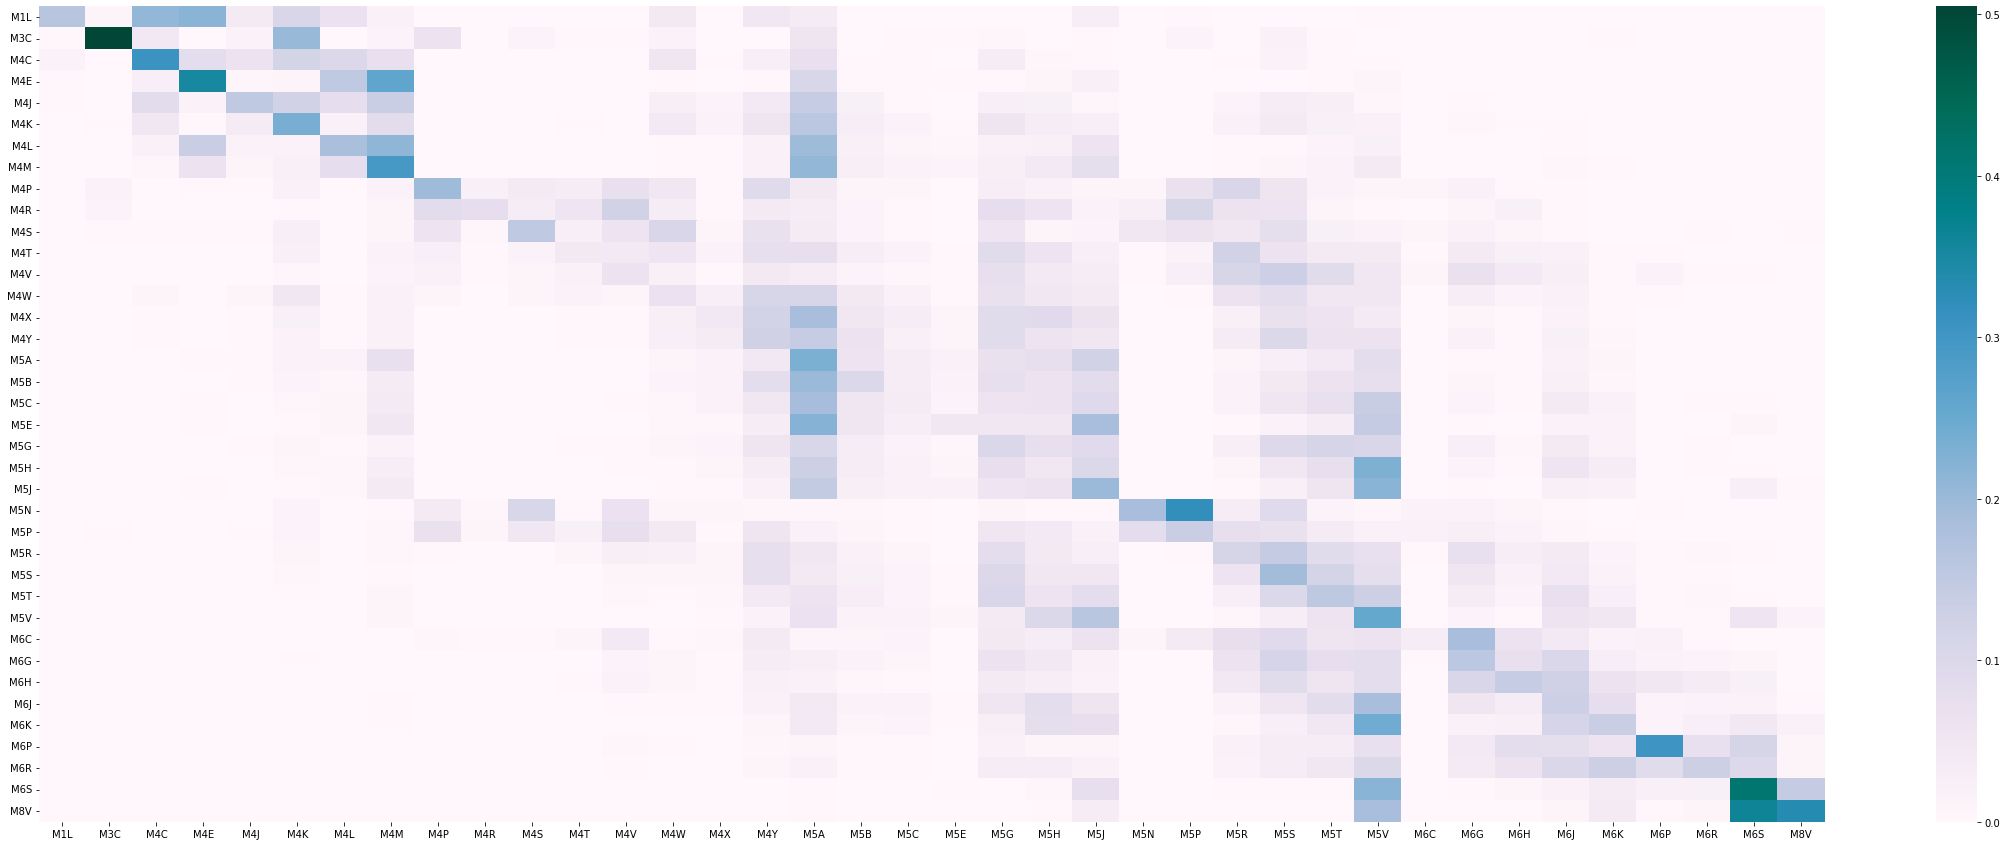

Dissemination Area
Max Value:  0.545945945945946


,35200523,35200567,35200576,35200583,35200588,35200591,35200596,35200598,35200605,35200643,35200654,35200660,35200674,35200678,35200696,35200703,35200705,35200708,35200710,35200732,35200737,35200741,35200745,35200747,35200749,35200751,35200757,35200771,35200783,35200791,35200792,35200797,35200801,35200805,35200813,35200821,35200822,35200826,35200832,35200833,...,35204625,35204632,35204634,35204653,35204655,35204661,35204663,35204666,35204675,35204692,35204749,35204750,35204757,35204819,35204820,35204822,35204825,35204826,35204827,35204841,35204842,35204843,35204844,35204845,35204867,35204871,35204872,35204873,35204881,35204882,35204883,35204888,35204894,35204895,35204896,35204897,35204898,35204899,35204900,35204901
35200523,0.107759,0.068966,0.107759,0.012931,0.021552,0.008621,0.000000,0.000000,0.030172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004310,0.000000,0.012931,0.008621,0.004310,0.021552,0.043103,0.021552,0.000000,0.000000,0.000000,0.030172,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004310,0.000000,0.0,0.000000,0.000000,0.000000,0.004310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200567,0.027073,0.049069,0.013536,0.006768,0.003384,0.003384,0.005076,0.005076,0.045685,0.000000,0.000000,0.001692,0.000000,0.000000,0.005076,0.021997,0.015228,0.018613,0.013536,0.006768,0.032149,0.035533,0.005076,0.000000,0.000000,0.000000,0.003384,0.000000,0.005076,0.008460,0.000000,0.000000,0.010152,0.001692,0.000000,0.000000,0.000000,0.000000,0.001692,0.001692,...,0.000000,0.0,0.028765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.001692,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.006768
35200576,0.063584,0.011561,0.057803,0.025048,0.073218,0.028902,0.015414,0.003854,0.028902,0.000000,0.001927,0.001927,0.003854,0.001927,0.003854,0.005780,0.005780,0.023121,0.026975,0.019268,0.017341,0.077071,0.003854,0.000000,0.000000,0.000000,0.003854,0.000000,0.013487,0.015414,0.000000,0.007707,0.003854,0.011561,0.001927,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.013487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005780,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.019268,0.001927,0.000000,0.000000,0.001927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015414
35200583,0.003626,0.002720,0.012693,0.027199,0.029012,0.029012,0.012693,0.013599,0.011786,0.006346,0.008160,0.002720,0.002720,0.002720,0.011786,0.011786,0.000907,0.021759,0.014506,0.006346,0.004533,0.028105,0.000000,0.000907,0.001813,0.000000,0.005440,0.000907,0.023572,0.011786,0.001813,0.001813,0.001813,0.008160,0.000000,0.000000,0.000000,0.000000,0.019039,0.000000,...,0.000000,0.0,0.037171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003626,0.000000,0.000000,0.001813,0.001813,0.000000,0.0,0.001813,0.000000,0.000000,0.020852,0.000907,0.003626,0.000907,0.000000,0.000000,0.004533,0.000907,0.000907,0.000907,0.001813,0.001813
35200588,0.014847,0.004367,0.038428,0.029694,0.032314,0.020961,0.020961,0.020961,0.033188,0.002620,0.009607,0.006114,0.013100,0.007860,0.001747,0.009607,0.001747,0.028821,0.020087,0.001747,0.002620,0.020961,0.000000,0.000000,0.000000,0.000000,0.001747,0.000000,0.004367,0.011354,0.000873,0.040175,0.000873,0.001747,0.000000,0.000000,0.000000,0.000000,0.004367,0.000000,...,0.000000,0

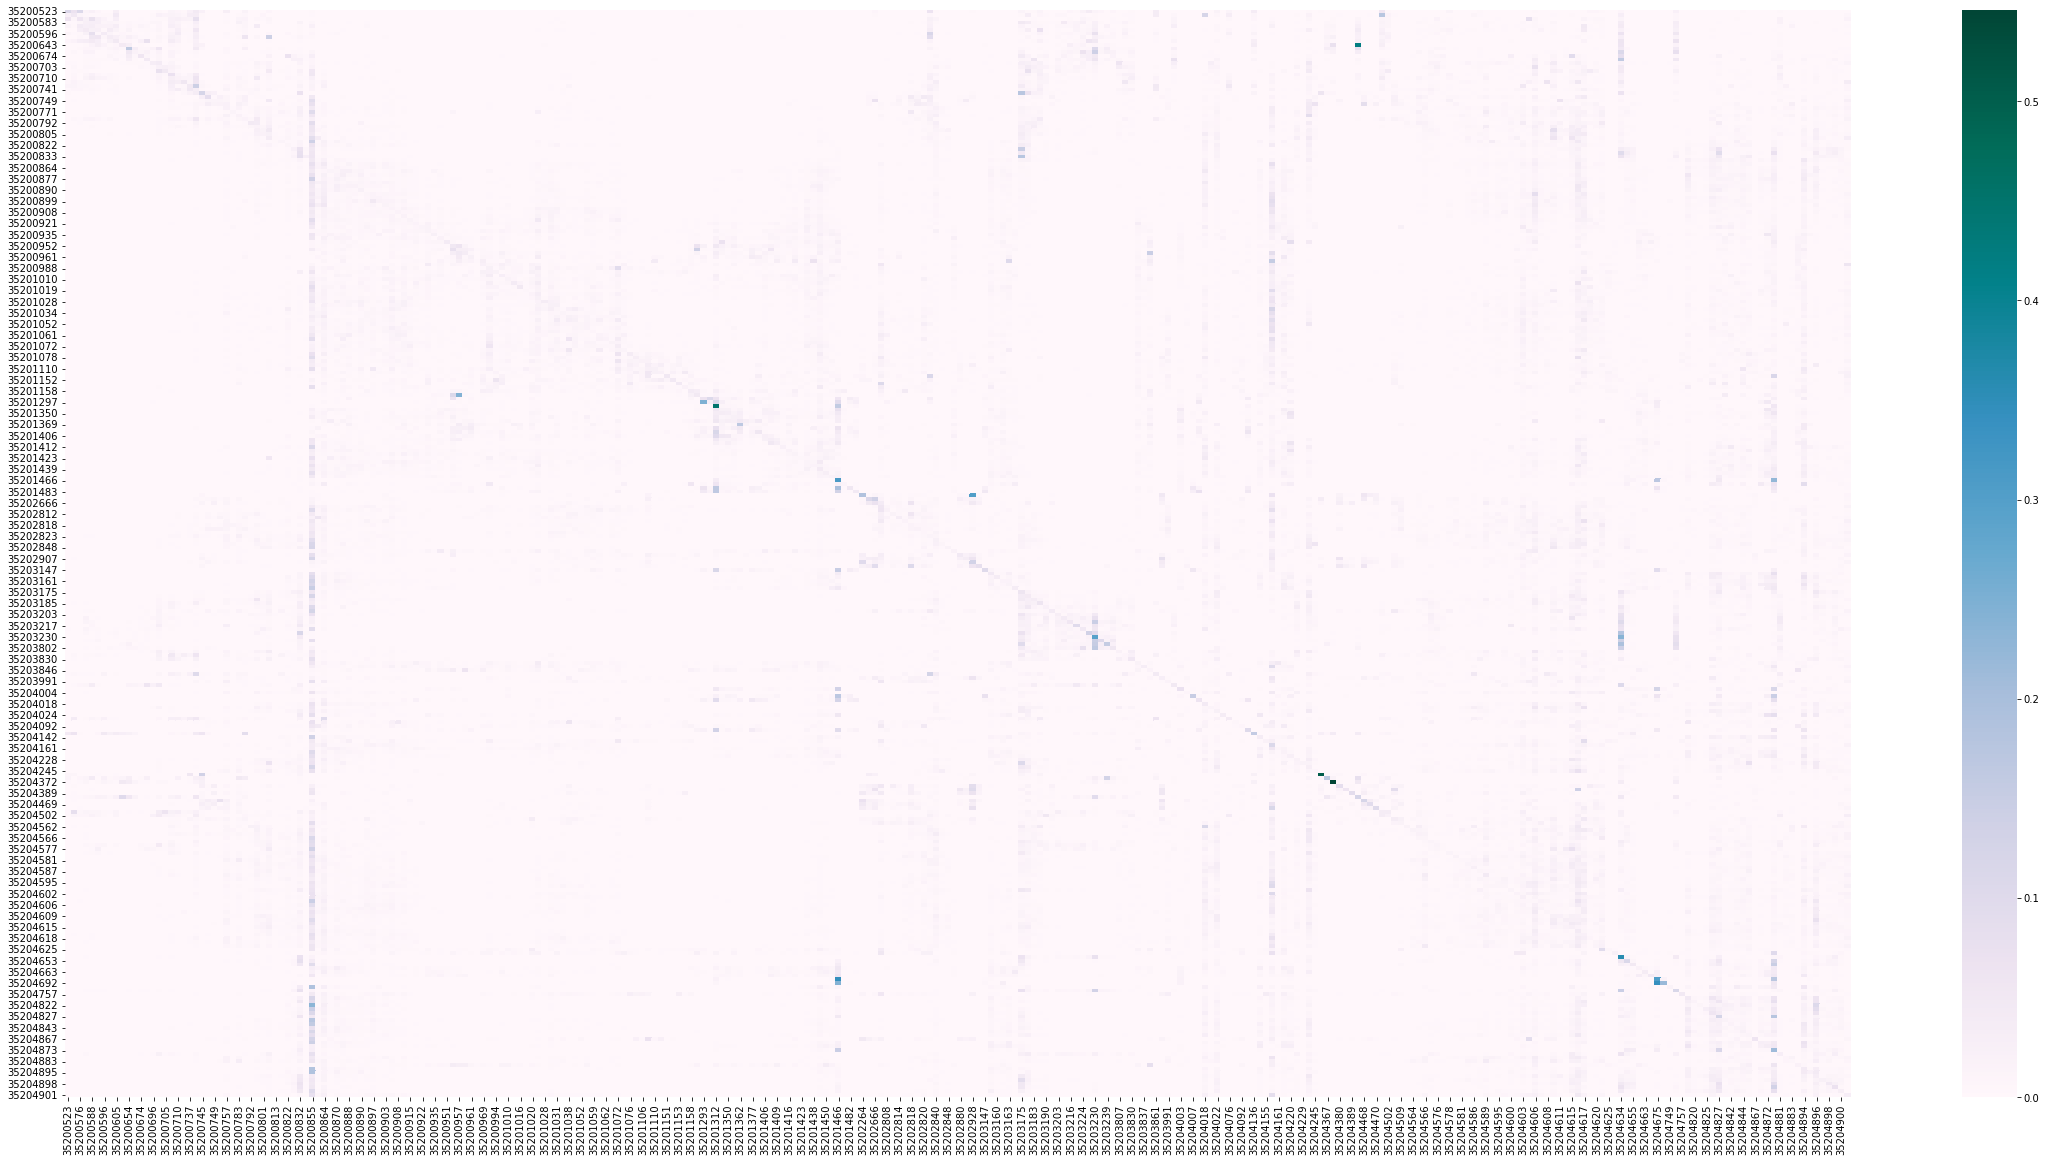

In [232]:
# 'Neighbourhood', 50 / 'Forward_Sortation_Area', 38 / 'Dissemination_Area', 292, for plotting DA: (40, 20)
# print('Neighbourhood')
# heatmap_matrix = compute_heatmap(heatmap_summer, 'Neighbourhood', 50)
# print('Max Value: ', heatmap_matrix.to_numpy().max())
# display(heatmap_matrix)
# plot_heatmap(heatmap_matrix, 'Neighbourhood-summer')

print('Forward Sortation Area')
heatmap_matrix = compute_heatmap(heatmap_summer, 'Forward_Sortation_Area', 38)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Forward_Sortation_Area-summer')

print('Dissemination Area')
heatmap_matrix = compute_heatmap(heatmap_summer, 'Dissemination_Area', 292)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Dissemination_Area-summer', (40, 20))

## 3.4 Winter

Forward Sortation Area
Max Value:  0.5


,M1L,M3C,M4C,M4E,M4J,M4K,M4L,M4M,M4P,M4R,M4S,M4T,M4V,M4W,M4X,M4Y,M5A,M5B,M5C,M5E,M5G,M5H,M5J,M5N,M5P,M5R,M5S,M5T,M5V,M6C,M6G,M6H,M6J,M6K,M6P,M6R,M6S,M8V
M1L,0.024390,0.000000,0.292683,0.243902,0.292683,0.073171,0.024390,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000
M3C,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M4C,0.015190,0.000000,0.270886,0.040506,0.084810,0.111392,0.048101,0.058228,0.000000,0.000000,0.000000,0.000000,0.000000,0.062025,0.005063,0.050633,0.078481,0.008861,0.013924,0.000000,0.029114,0.024051,0.008861,0.000000,0.000000,0.012658,0.034177,0.003797,0.003797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035443,0.000000
M4E,0.001984,0.000000,0.033730,0.448413,0.003968,0.017857,0.125000,0.212302,0.000000,0.000000,0.000000,0.000000,0.000000,0.001984,0.001984,0.000000,0.107143,0.001984,0.000000,0.001984,0.005952,0.009921,0.013889,0.000000,0.000000,0.001984,0.000000,0.003968,0.001984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003968,0.000000
M4J,0.004831,0.000000,0.083333,0.003623,0.189614,0.134058,0.050725,0.178744,0.000000,0.000000,0.000000,0.000000,0.000000,0.020531,0.009662,0.025362,0.112319,0.012077,0.007246,0.000000,0.041063,0.007246,0.008454,0.000000,0.000000,0.012077,0.012077,0.067633,0.006039,0.000000,0.002415,0.002415,0.001208,0.000000,0.000000,0.000000,0.007246,0.000000
M4K,0.000365,0.001461,0.047863,0.001461,0.063573,0.294848,0.007673,0.086957,0.000365,0.000000,0.000000,0.005115,0.001827,0.031056,0.016076,0.042382,0.120935,0.018268,0.006211,0.001096,0.086226,0.021556,0.016076,0.000000,0.000000,0.019730,0.037998,0.035440,0.023383,0.000000,0.005115,0.001461,0.001827,0.000365,0.000000,0.000000,0.003288,0.000000
M4L,0.000000,0.000000,0.034745,0.116178,0.018458,0.008686,0.152009,0.184582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004343,0.024973,0.187839,0.024973,0.035831,0.026059,0.046688,0.078176,0.024973,0.000000,0.000000,0.002172,0.008686,0.008686,0.006515,0.000000,0.002172,0.001086,0.000000,0.000000,0.000000,0.000000,0.002172,0.000000
M4M,0.000000,0.000000,0.007307,0.027918,0.021735,0.026607,0.050028,0.178190,0.000749,0.000187,0.000749,0.000937,0.002811,0.008057,0.008057,0.023421,0.251452,0.037662,0.024171,0.008244,0.075511,0.068765,0.061458,0.000000,0.000375,0.003935,0.012741,0.026232,0.057710,0.000000,0.001124,0.000000,0.011430,0.002248,0.000000,0.000000,0.000187,0.000000
M4P,0.000000,0.000000,0.000000,0.000000,0.005495,0.021978,0.000000,0.021978,0.225275,0.060440,0.021978,0.021978,0.093407,0.021978,0.016484,0.098901,0.027473,0.010989,0.000000,0.000000,0.027473,0.000000,0.000000,0.021978,0.120879,0.082418,0.027473,0.005495,0.005495,0.016484,0.038462,0.000000,0.005495,0.000000,0.000000,0.000000,0.000000,0.000000
M4R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.020833,0.020833,0.041667,0.000000,0.270833,0.000000,0.000000,0.166667,0.041667,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.020833,0.166667,0.062500,0.041667,0.062500,0.000000,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000


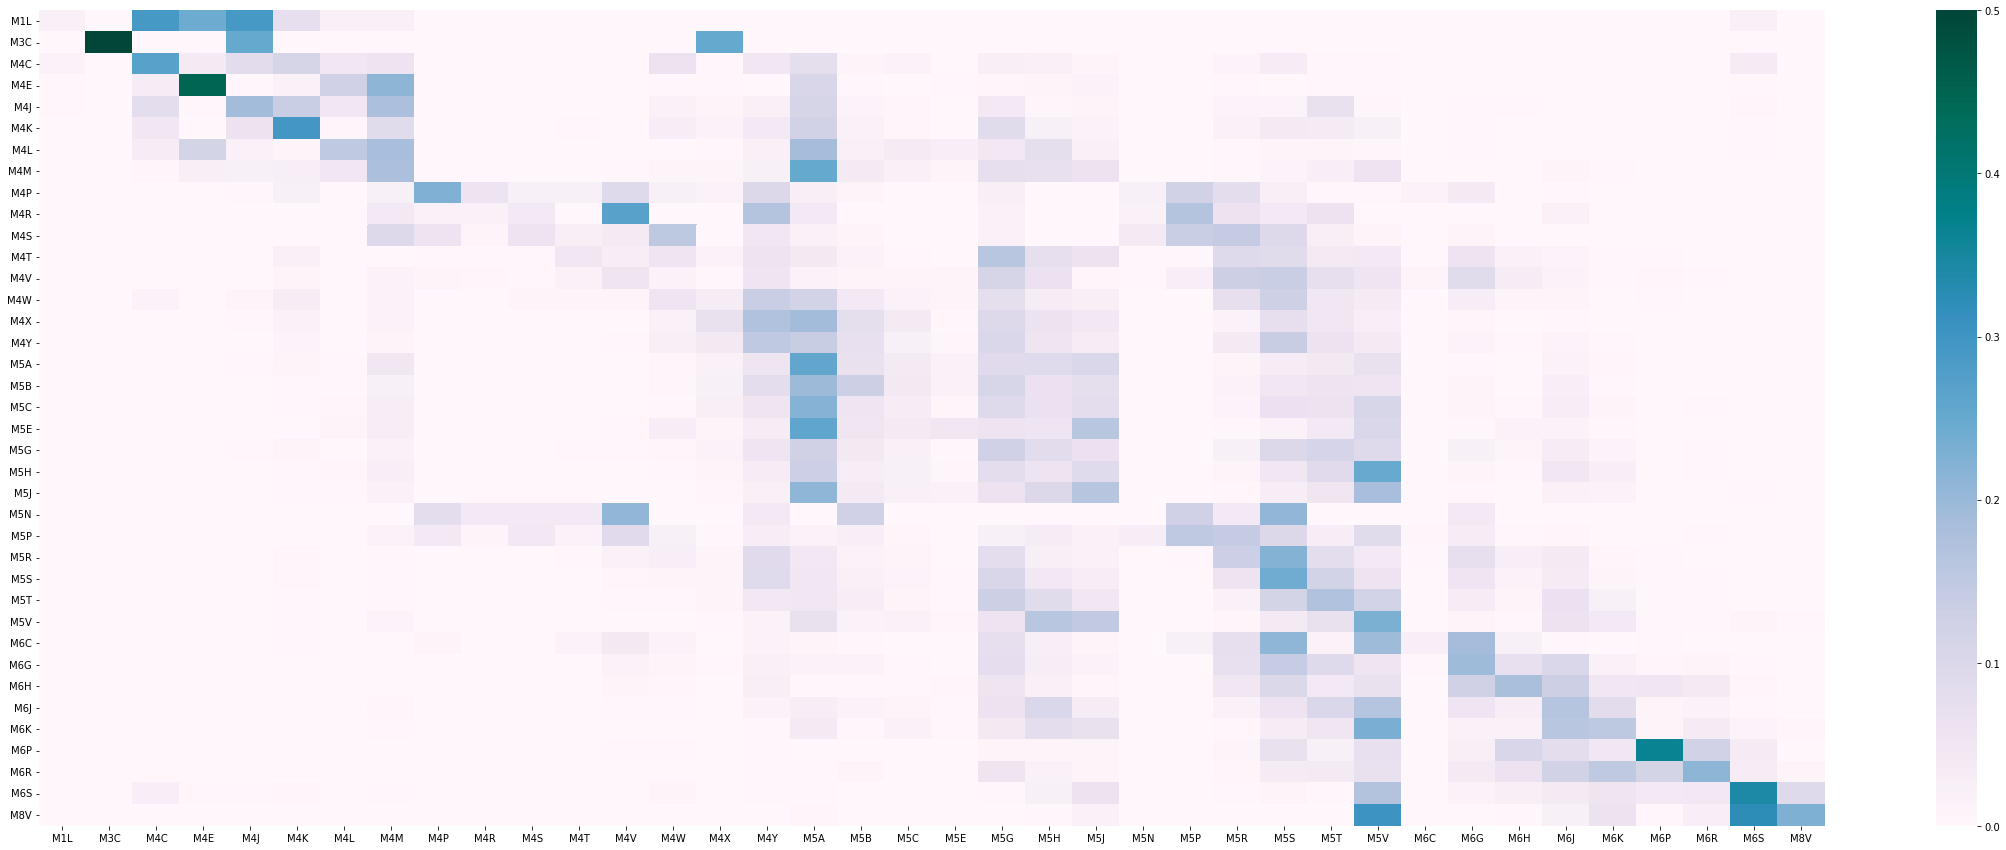

Dissemination Area
Max Value:  0.6470588235294118


,35200523,35200567,35200576,35200583,35200588,35200591,35200596,35200598,35200605,35200643,35200654,35200660,35200674,35200678,35200696,35200703,35200705,35200708,35200710,35200732,35200737,35200741,35200745,35200747,35200749,35200751,35200757,35200771,35200783,35200791,35200792,35200797,35200801,35200805,35200813,35200821,35200822,35200826,35200832,35200833,...,35204625,35204632,35204634,35204653,35204655,35204661,35204663,35204666,35204675,35204692,35204749,35204750,35204757,35204819,35204820,35204822,35204825,35204826,35204827,35204841,35204842,35204843,35204844,35204845,35204867,35204871,35204872,35204873,35204881,35204882,35204883,35204888,35204894,35204895,35204896,35204897,35204898,35204899,35204900,35204901
35200523,0.040000,0.160000,0.040000,0.020000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200567,0.024000,0.032000,0.000000,0.024000,0.032000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008000,0.000000,0.016000,0.008000,0.024000,0.008000,0.016,0.024000,0.032,0.016000,0.0,0.0,0.000000,0.000000,0.008000,0.008000,0.000000,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200576,0.008264,0.016529,0.041322,0.016529,0.099174,0.033058,0.000000,0.000000,0.008264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016529,0.000000,0.000000,0.000000,0.057851,0.000,0.033058,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.148760,0.057851,0.008264,0.016529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.008264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200583,0.004854,0.000000,0.009709,0.029126,0.019417,0.077670,0.000000,0.004854,0.000000,0.000000,0.000000,0.004854,0.000000,0.014563,0.014563,0.053398,0.004854,0.000000,0.082524,0.033981,0.000,0.038835,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.014563,0.000000,0.000000,0.000000,0.004854,0.000000,0.000000,0.004854,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.004854,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.014563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009709,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35200588,0.009709,0.029126,0.048544,0.019417,0.019417,0.033981,0.004854,0.024272,0.000000,0.000000,0.019417,0.009709,0.004854,0.000000,0.004854,0.004854,0.000000,0.004854,0.009709,0.000000,0.000,0.048544,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.004854,0.000000,0.000000,0.019417,0.000000,0.004854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.024272,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.004854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

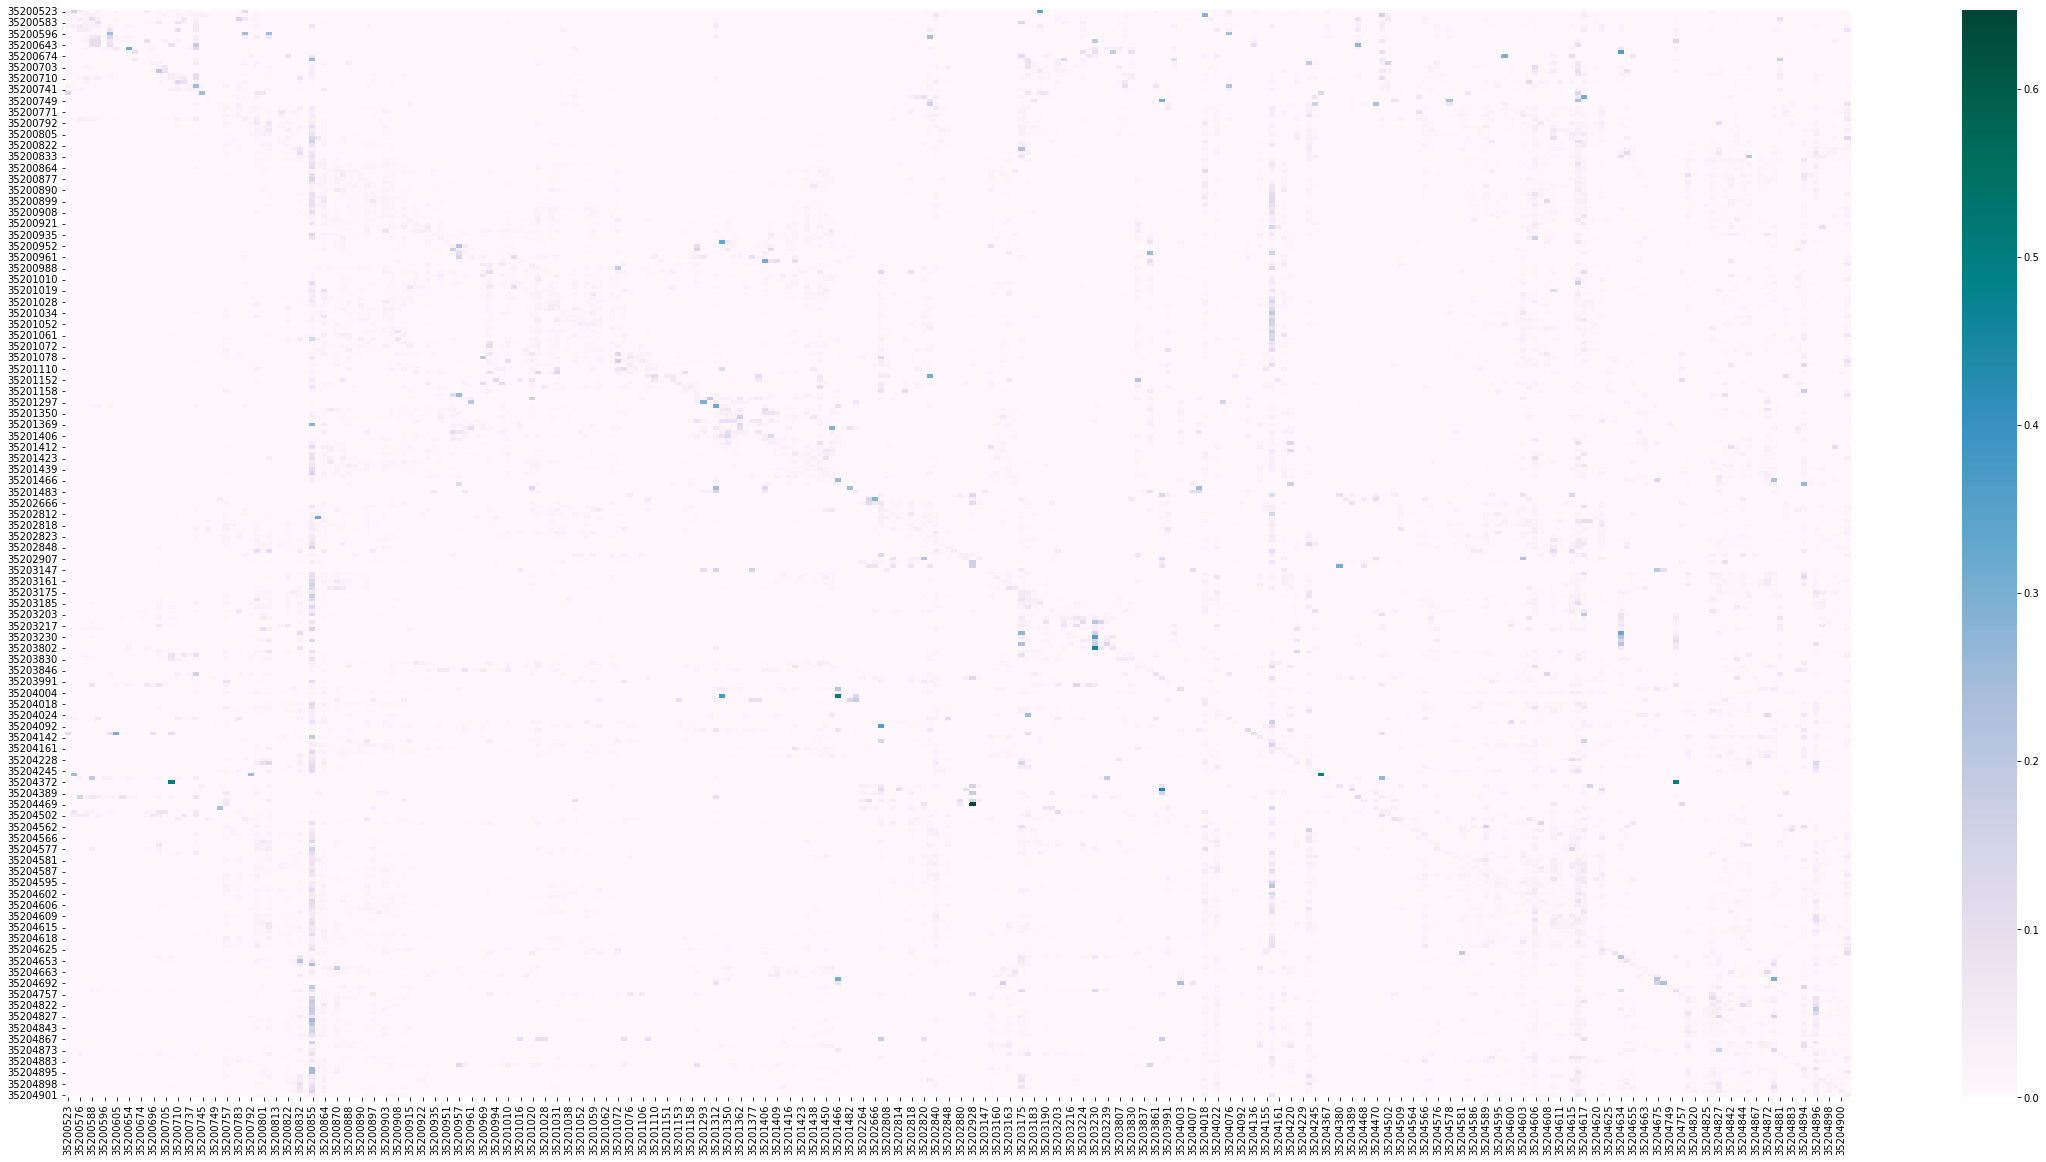

In [233]:
# 'Neighbourhood', 50 / 'Forward_Sortation_Area', 38 / 'Dissemination_Area', 292, for plotting DA: (40, 20)
# print('Neighbourhood')
# heatmap_matrix = compute_heatmap(heatmap_winter, 'Neighbourhood', 50)
# print('Max Value: ', heatmap_matrix.to_numpy().max())
# display(heatmap_matrix)
# plot_heatmap(heatmap_matrix, 'Neighbourhood-winter')

print('Forward Sortation Area')
heatmap_matrix = compute_heatmap(heatmap_winter, 'Forward_Sortation_Area', 38)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Forward_Sortation_Area-winter')

print('Dissemination Area')
heatmap_matrix = compute_heatmap(heatmap_winter, 'Dissemination_Area', 292)
print('Max Value: ', heatmap_matrix.to_numpy().max())
display(heatmap_matrix)
plot_heatmap(heatmap_matrix, 'Dissemination_Area-winter', (40, 20))

# 4.0 Download Files

In [ ]:
checkout_in_list = ['Checkout', 'Checkin']
day_of_week_list = ['Weekdays', 'Weekends_Holidays']
day_division_list = ['Morning Peak Hours', 'Day Hours', 'Evening Peak Hours', 'Night Hours']
# region_division_list = ['Dissemination_Area', 'Neighbourhood', 'Forward_Sortation_Area']
region_division_list = ['Dissemination_Area', 'Forward_Sortation_Area']
season_list = ['springfall', 'summer', 'winter']

# download map html files
for c in checkout_in_list:
  for region in region_division_list:
    for dayofweek in day_of_week_list:
      for day_div in day_division_list:
        file_name = f'{region}-{c}_{dayofweek}_{day_div}.html'
        print(file_name)
        files.download(file_name)

# download heatmaps
# for region in region_division_list:
#   for season in season_list:
#     file_name = f'{region}-{season}.png'
#     print(file_name)
#     files.download(file_name)

- Plot choropleth & heatmap for:
1. toronto neighbourhoods
2. FSAs
3. dissemination area

- Find definitions for these divisions
- Analyze any patterns in the data from looking at the geographic regions
- Produce a comprehensive EDA report


- Read clustering algorithm from paper + write in latex

In [ ]:
# DataFrames by weekday/weekend/holidays: df_weekday, df_weekend, df_holidays
# Test for one dataframe, group data by hour
df1, df2, df3, df4 = split_time_periods(df_weekday)
trip_counts = df1[['Trip Id', 'Neighbourhood']].groupby(by=['Neighbourhood']).count()
trip_counts.rename(columns={'Trip Id': 'Number of Trips'}, inplace=True)
trip_counts.reset_index(inplace=True)
print(trip_counts.shape)
trip_counts.head()

# trip_num_hour_annual, trip_num_hour_casual = split_into_annual_casual(trip_counts)

(51, 2)


,Neighbourhood,Number of Trips
0,17,1478
1,44,24
2,57,2073
3,58,1056
4,59,597


In [ ]:
create_choropleth_map(trip_counts, 'Weekdays Morning Rush Hours')